In [ ]:
# import os
# import pandas as pd
# import joblib
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # --------------------------
# # Configuration
# # --------------------------
# DATA_FOLDER = "data"
# EXPECTED_COLS = [
#     'Sample ID',
#     'pH',
#     'Temperature (°C)',
#     'Turbidity (NTU)',
#     'Dissolved Oxygen (mg/L)',
#     'Conductivity (µS/cm)'
# ]

# # --------------------------
# # Load & Merge CSV Files
# # --------------------------
# all_data = pd.DataFrame()

# for file in os.listdir(DATA_FOLDER):
#     if file.endswith(".csv"):
#         df = pd.read_csv(os.path.join(DATA_FOLDER, file))
#         if list(df.columns) == EXPECTED_COLS:
#             all_data = pd.concat([all_data, df], ignore_index=True)
#         else:
#             print(f"⚠️ Skipped {file}: Invalid columns")

# if all_data.empty:
#     raise ValueError("No valid CSV files found in the data folder!")

# print(f"✅ Loaded {len(all_data)} rows from {DATA_FOLDER}")

# # --------------------------
# # Train Model for Dissolved Oxygen
# # --------------------------
# X_do = all_data.drop(columns=["Sample ID", "Dissolved Oxygen (mg/L)"])
# y_do = all_data["Dissolved Oxygen (mg/L)"]

# X_train_do, X_test_do, y_train_do, y_test_do = train_test_split(
#     X_do, y_do, test_size=0.2, random_state=42
# )

# model_do = XGBRegressor(
#     random_state=42,
#     n_estimators=200,
#     max_depth=4,
#     learning_rate=0.1,
#     n_jobs=-1
# )
# model_do.fit(X_train_do, y_train_do)

# pred_do = model_do.predict(X_test_do)
# print("\nDissolved Oxygen Model:")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_do, pred_do)))
# print("R²:", r2_score(y_test_do, pred_do))

# joblib.dump(model_do, "model_DO.pkl")
# print("✅ Saved model_DO.pkl")

# # --------------------------
# # Train Model for Conductivity
# # --------------------------
# X_c = all_data.drop(columns=["Sample ID", "Conductivity (µS/cm)"])
# y_c = all_data["Conductivity (µS/cm)"]

# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
#     X_c, y_c, test_size=0.2, random_state=42
# )

# model_c = XGBRegressor(
#     random_state=42,
#     n_estimators=200,
#     max_depth=4,
#     learning_rate=0.1,
#     n_jobs=-1
# )
# model_c.fit(X_train_c, y_train_c)

# pred_c = model_c.predict(X_test_c)
# print("\nConductivity Model:")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_c, pred_c)))
# print("R²:", r2_score(y_test_c, pred_c))

# joblib.dump(model_c, "model_conductivity.pkl")
# print("✅ Saved model_conductivity.pkl")


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:

file_path = "WaterQuality data.xlsx"
sheet_names = ["sheet1", "sheet2", "sheet3", "sheet4", "sheet5"]

# Read only those sheets
sheets = pd.read_excel(file_path, sheet_name=sheet_names)

# Combine and keep source sheet name
frames = []
for name in sheet_names:
    df = sheets[name].copy()
    # (optional) normalize column names a bit
    df.columns = [str(c).strip() for c in df.columns]
    df["source_sheet"] = name
    frames.append(df)

combined_df = pd.concat(frames, ignore_index=True, sort=False)

# Put source column first
combined_df = combined_df[["source_sheet"] + [c for c in combined_df.columns if c != "source_sheet"]]

df=combined_df

print(df.shape)
df.head()


(2500, 7)


,source_sheet,sample_id,ph,temperature_(°c),turbidity_(ntu),dissolved_oxygen_(mg/l),conductivity_(µs/cm)
0,sheet1,1,7.25,23.1,4.5,7.8,342
1,sheet1,2,7.11,22.3,5.1,6.2,335
2,sheet1,3,7.03,21.5,3.9,8.3,356
3,sheet1,4,7.38,22.9,3.2,9.5,327
4,sheet1,5,7.45,20.7,3.8,8.1,352


In [5]:
# checking null values
df.isnull().sum()

source_sheet               0
sample_id                  0
ph                         0
temperature_(°c)           0
turbidity_(ntu)            0
dissolved_oxygen_(mg/l)    0
conductivity_(µs/cm)       0
dtype: int64

We are using this data to inform our decision-making and to ensure that our policies and procedures are effective in addressing the needs of our community. 
We are committed to transparency and accountability in our decision-making processes. We will continue to engage with our community and provide updates on our progress.
We are training the model to predict conductivity of water.

Conductivity (µS/cm)
A measure of water’s ability to conduct electricity, which depends on dissolved ions (salts, minerals, pollutants).

Effect on water quality:

High conductivity = higher mineral/salt content (can be natural or from pollution).

Very low conductivity may indicate pure water, which is rare in nature.

Relations with other variables:

Can increase with pollution, agricultural runoff, or industrial discharge.

Often correlates with pH changes if pollutants are present.

In [7]:
# ---------- 2) Define targets & features ----------
TARGET_COLS = ["dissolved_oxygen_(mg/l)", "conductivity_(µs/cm)"]
ID_COLS = ["source_sheet", "sample_id"]  # drop these from features if present

# Validate targets exist
missing_targets = [c for c in TARGET_COLS if c not in df.columns]
if missing_targets:
    raise ValueError(f"Missing target columns in data: {missing_targets}")

# (Optional but robust) Coerce any non-numeric predictors to numeric if they slipped in as text
for c in df.columns:
    if c not in ID_COLS + TARGET_COLS:
        if df[c].dtype == "object":
            # Try to coerce numeric-looking strings
            df[c] = pd.to_numeric(
                df[c].astype(str).str.replace(",", "", regex=False).str.replace(r"[^\d\.\-eE]", "", regex=True),
                errors="coerce"
            )

# Build X (numeric only) and y
X = df.drop(columns=[c for c in (ID_COLS + TARGET_COLS) if c in df.columns], errors="ignore")
X = X.select_dtypes(include=["number"]).copy()

y = df[TARGET_COLS].copy()

if X.shape[1] == 0:
    raise ValueError("No numeric feature columns found after dropping IDs and targets. Check your inputs.")

# Handle inf/nans safely
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))
y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median(numeric_only=True))

print("Feature columns used:", list(X.columns))

# ---------- 3) Train/validation split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- 4) Model: MultiOutputRegressor with XGBRegressor (RF fallback) ----------
try:
    import xgboost as xgb
    base_reg = xgb.XGBRegressor(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
    )
    used_model = "XGBRegressor"
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    base_reg = RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42,
    )
    used_model = "RandomForestRegressor (fallback)"

model = MultiOutputRegressor(base_reg)

# ---------- 5) Fit ----------
model.fit(X_train, y_train)

# ---------- 6) Evaluate (version-safe RMSE) ----------
def rmse(y_true, y_hat):
    y_true = np.asarray(y_true).ravel()
    y_hat  = np.asarray(y_hat).ravel()
    return float(np.sqrt(mean_squared_error(y_true, y_hat)))

y_pred = model.predict(X_test)
print(f"\nBase model used: {used_model}")

# Ensure numpy arrays for clean indexing
y_pred = np.asarray(y_pred)

for i, tgt in enumerate(TARGET_COLS):
    y_true_i = y_test.iloc[:, i].to_numpy()
    y_hat_i  = y_pred[:, i]
    print(f"{tgt:28s} R2 = {r2_score(y_true_i, y_hat_i):.4f} | RMSE = {rmse(y_true_i, y_hat_i):.4f}")

# ---------- 7) (Optional) Avg feature importances across outputs ----------
try:
    importances = np.zeros(X.shape[1]); n = 0
    for est in model.estimators_:
        if hasattr(est, "feature_importances_"):
            importances += est.feature_importances_; n += 1
    if n > 0:
        importances /= n
        fi = pd.Series(importances, index=X.columns).sort_values(ascending=False)
        print("\nTop features (avg across outputs):")
        print(fi.head(10))
except Exception:
    pass

# ---------- 8) Save for later (e.g., Streamlit) ----------
joblib.dump(
    {"model": model, "feature_columns": X.columns.tolist(), "targets": TARGET_COLS},
    "multioutput_water_model.pkl"
)
print("\nModel saved to multioutput_water_model.pkl")


Feature columns used: ['ph', 'temperature_(°c)', 'turbidity_(ntu)']

Base model used: XGBRegressor
dissolved_oxygen_(mg/l)      R2 = 0.9909 | RMSE = 0.0776
conductivity_(µs/cm)         R2 = 0.9966 | RMSE = 0.7621

Top features (avg across outputs):
ph                  0.611917
temperature_(°c)    0.218623
turbidity_(ntu)     0.169460
dtype: float64

Model saved to multioutput_water_model.pkl


Exploratory Data Analysis (EDA) is a process of summarizing and visualizing data to understand its underlying structure 

Histograms: ranges & skew (e.g., conductivity heavy tail).

Boxplots by sheet: any sensor/file-specific bias.

Scatter pairs: expected DO↓ with Temp↑, conductivity vs pH/turbidity patterns.

Correlation heatmap: strongest linear relationships at a glance.


C:\Users\vamsi\AppData\Local\Temp\ipykernel_16124\2266586441.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sheets_order, showfliers=True)


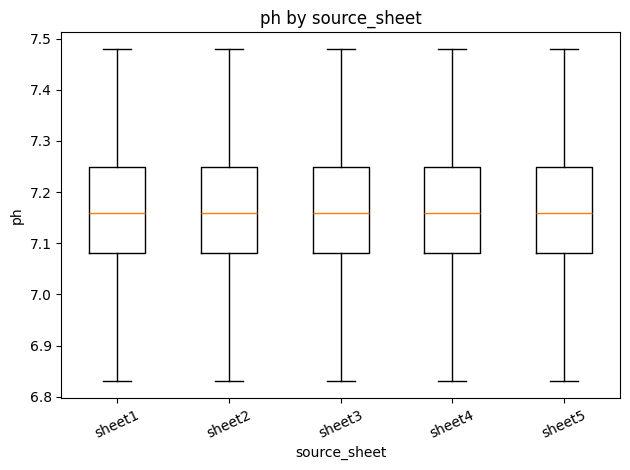

C:\Users\vamsi\AppData\Local\Temp\ipykernel_16124\2266586441.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sheets_order, showfliers=True)


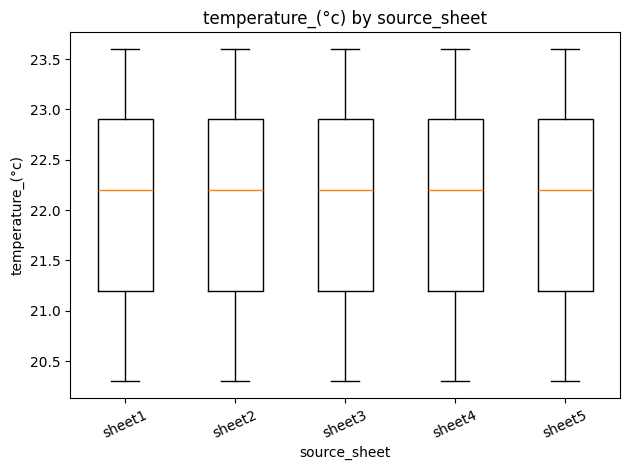

C:\Users\vamsi\AppData\Local\Temp\ipykernel_16124\2266586441.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sheets_order, showfliers=True)


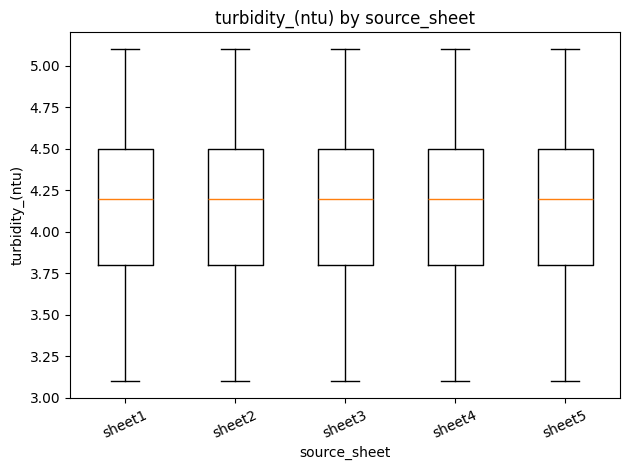

C:\Users\vamsi\AppData\Local\Temp\ipykernel_16124\2266586441.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sheets_order, showfliers=True)


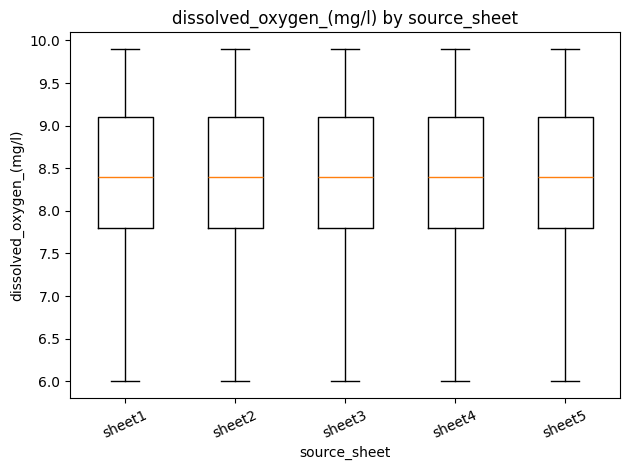

C:\Users\vamsi\AppData\Local\Temp\ipykernel_16124\2266586441.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sheets_order, showfliers=True)


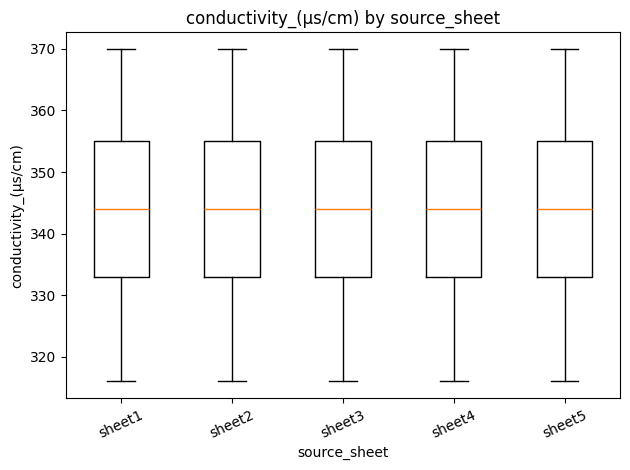

In [9]:
num_cols = [
    "ph", "temperature_(°c)", "turbidity_(ntu)",
    "dissolved_oxygen_(mg/l)", "conductivity_(µs/cm)"
]
for col in num_cols:
    if "source_sheet" in df.columns:
        plt.figure()
        sheets_order = df["source_sheet"].astype(str).unique().tolist()
        data = [df.loc[df["source_sheet"] == g, col].dropna().values for g in sheets_order]
        plt.boxplot(data, labels=sheets_order, showfliers=True)
        plt.xlabel("source_sheet"); plt.ylabel(col)
        plt.title(f"{col} by source_sheet")
        plt.xticks(rotation=25)
        plt.tight_layout()
        plt.show()

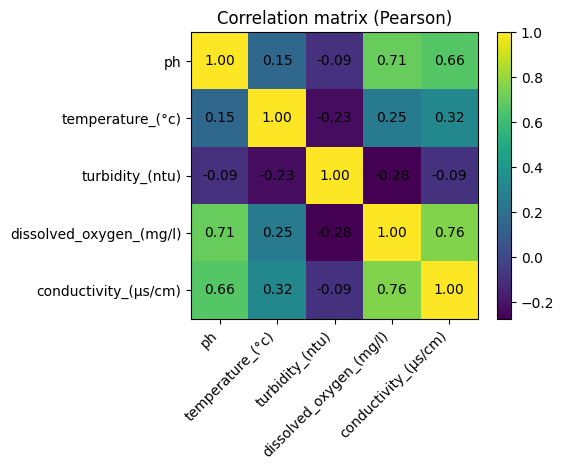

In [10]:
corr = df[num_cols].corr()
plt.figure()
im = plt.imshow(corr.values, interpolation="nearest")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
# annotate cells
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        plt.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")
plt.title("Correlation matrix (Pearson)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

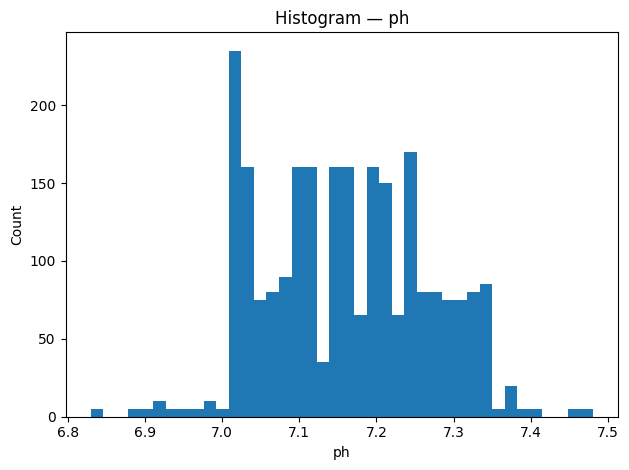

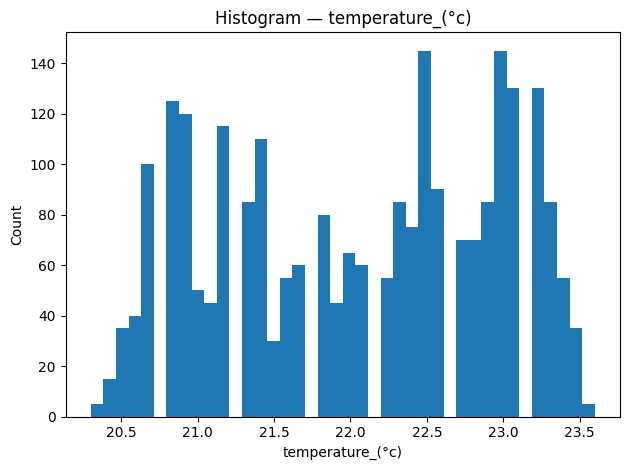

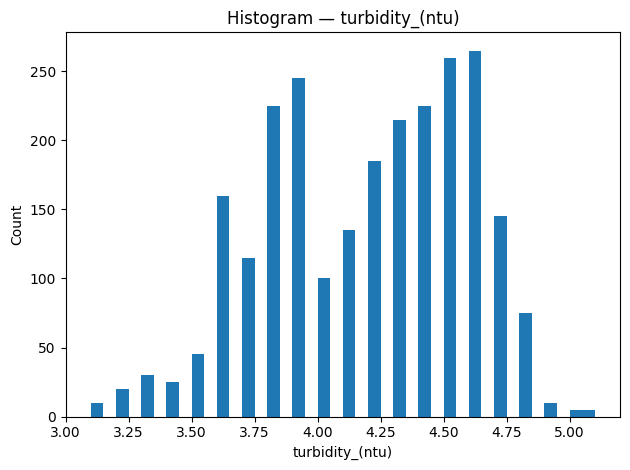

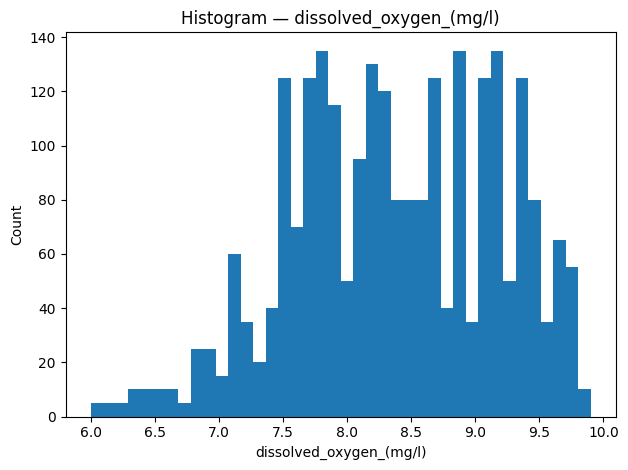

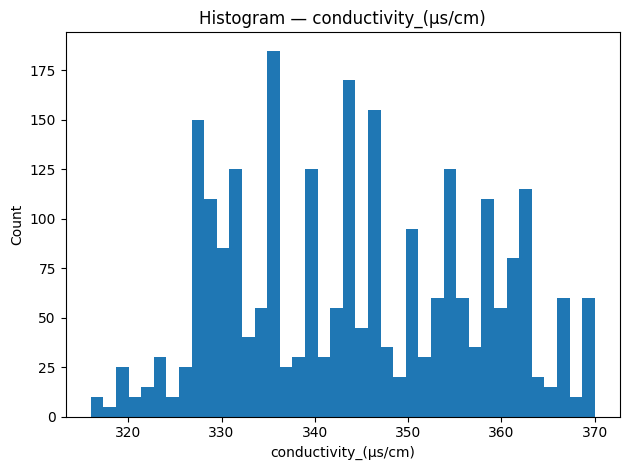

In [11]:
#  Histogram
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=40)
    plt.xlabel(col); plt.ylabel("Count")
    plt.title(f"Histogram — {col}")
    plt.tight_layout()
    plt.show()

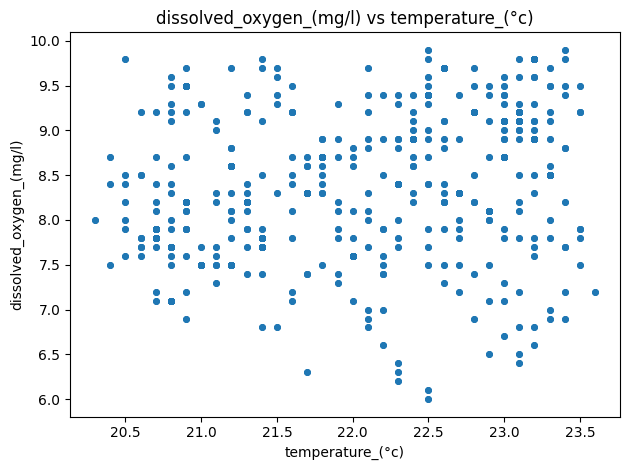

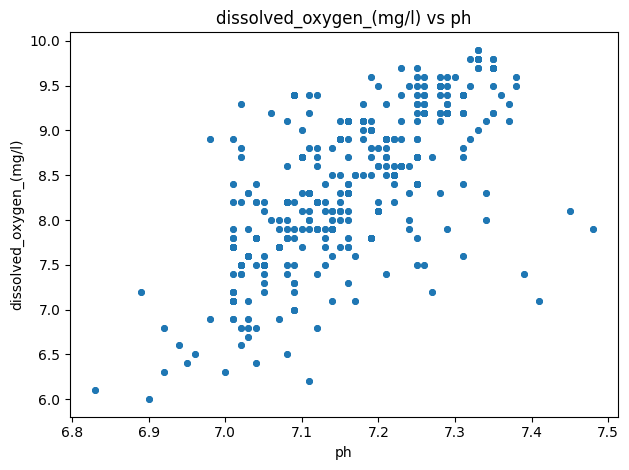

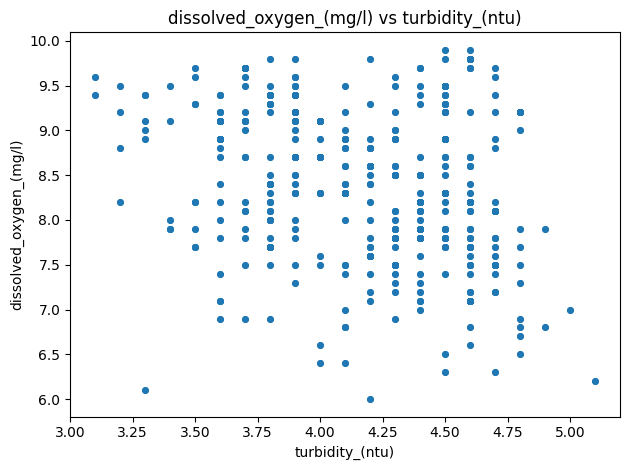

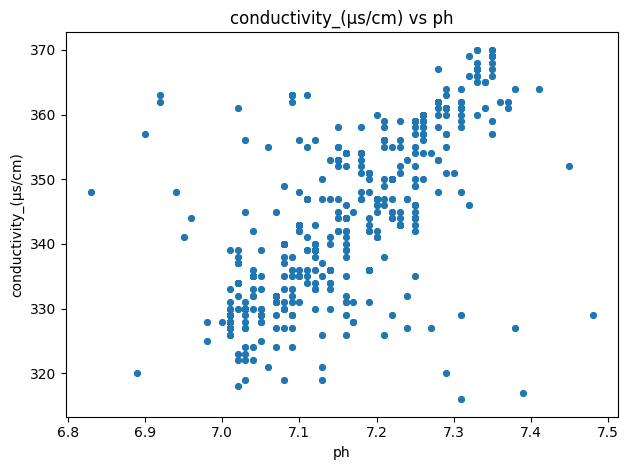

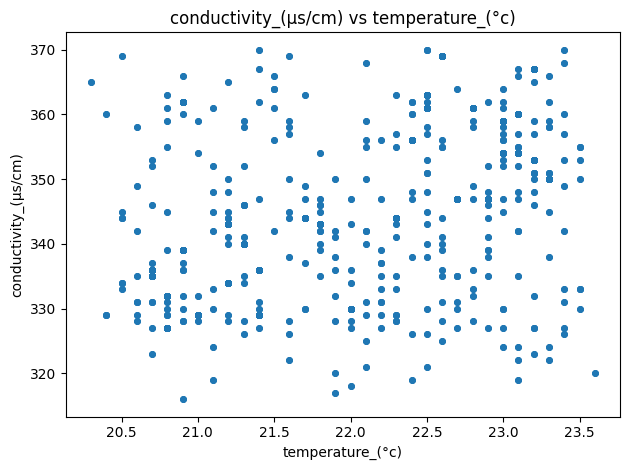

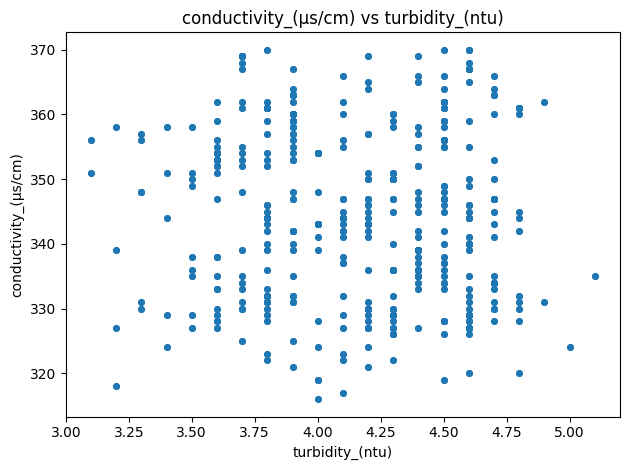

In [12]:
# ---------- 3) Key scatter relationships ----------
pairs = [
    ("temperature_(°c)", "dissolved_oxygen_(mg/l)"),  # DO vs Temp
    ("ph", "dissolved_oxygen_(mg/l)"),               # DO vs pH
    ("turbidity_(ntu)", "dissolved_oxygen_(mg/l)"),  # DO vs Turbidity
    ("ph", "conductivity_(µs/cm)"),                  # Cond vs pH
    ("temperature_(°c)", "conductivity_(µs/cm)"),    # Cond vs Temp
    ("turbidity_(ntu)", "conductivity_(µs/cm)"),     # Cond vs Turbidity
]
for x, y in pairs:
    if x in df.columns and y in df.columns:
        plt.figure()
        plt.scatter(df[x], df[y], s=14, alpha=0.8)
        plt.xlabel(x); plt.ylabel(y)
        plt.title(f"{y} vs {x}")
        plt.tight_layout()
        plt.show()